Le **clustering** est une tâche qui consiste à automatiquement grouper des objets similaires. On cherche à minimiser la distance inter-groupement et à maximiser la distance entre les groupements (les definitions varient légèrement selon les papiers cependant).

Les algorithmes de clustering sont très utiles pour faire de *l'analyse de données exploratoire*, c'est à dire pour étudier un dataset et le faire parler sans connaissance à priori dessus. Les cas d'utilisations sont divers: labeliser automatiquement un jeu de données (étape coûteuse si faite par un expert), [découvrir automatiquement des sujets de discussion](https://www.kdnuggets.com/2020/11/topic-modeling-bert.html), mieux comprendre le domaine sous-jascent, etc.


**HDBSCAN** (Hierarchichal DBSCAN) est un algorithme de clustering proposé par Campello et Al. en 2013 [2]. Il part du principe que:
- les algorithmes de clustering basés sur la densité, comme [DBSCAN](https://fr.wikipedia.org/wiki/DBSCAN), ne clusterisent que selon un seuil de densité global, ce qui va empecher de trouver des clusters de densité trop variables. 
- les algorithmes de type [clustering hierarchique](https://fr.wikipedia.org/wiki/Regroupement_hi%C3%A9rarchique) sont aussi intéressants, mais peuvent avoir une hiérarchie trop complexe, difficilement interprétable.
- Un autre problème rencontré est aussi la multiplication de paramètres, influençant grandement le résultat (par exemple le nombre de classes est à spécifier pour [k-means](https://fr.wikipedia.org/wiki/K-moyennes))

Notons qu'un algorithme de clustering est différent d'un algorithme de partitionnement, comme k-means. Le but de ce dernier est d'associer à tout élément un des k regroupements, en minimisant la distance intra-regroupement. Dans notre définition du clustering, on s'autorise à avoir des points qui n'appartiennent à aucun regroupement: ils sont considérés comme étant du *bruit*.

En deux mots, HDBSCAN est un mélange entre un algorithme de clustering hierarchique et DBSCAN. Il va permettre de considérer des clusters de densités différentes, ne requiert que peu de paramétrage, donne de très bons résultats. De plus, une implémentation performante et intégrée à sk-learn [a été proposée](https://github.com/scikit-learn-contrib/hdbscan) suite à des travaux plus récents [1].

**NB**: Les illustrations qui vont suivre sont prises depuis [4]. Ce notebook n'est pas une simple traduction mais une manière un peu différente de présenter l'algorithme.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}


### Définitions
**Core distance d'un point dcore(A)**: distance au mPts plus proche voisin.
Plus elle est petite, plus la densité de points est forte au voisinage d'un point

![](https://github.com/Romathonat/vulgaireDevEntries/blob/master/HDBSCAN/1.png?raw=true)

**Mutual Reachibility Distance dMRD(A, B)**: entre deux objets, la MRD est la valeur max entre la distance entre les deux objets, la core distance du premier object, et la core distance du deuxième objet.

Par exemple, la MRE entre le point vert et bleu va correspondre à la core distance du point vert, à la différence de la MRD entre le point vert et rouge, qui correpond à la distance entre ces deux points.


![](https://github.com/Romathonat/vulgaireDevEntries/blob/master/HDBSCAN/2.png?raw=true)
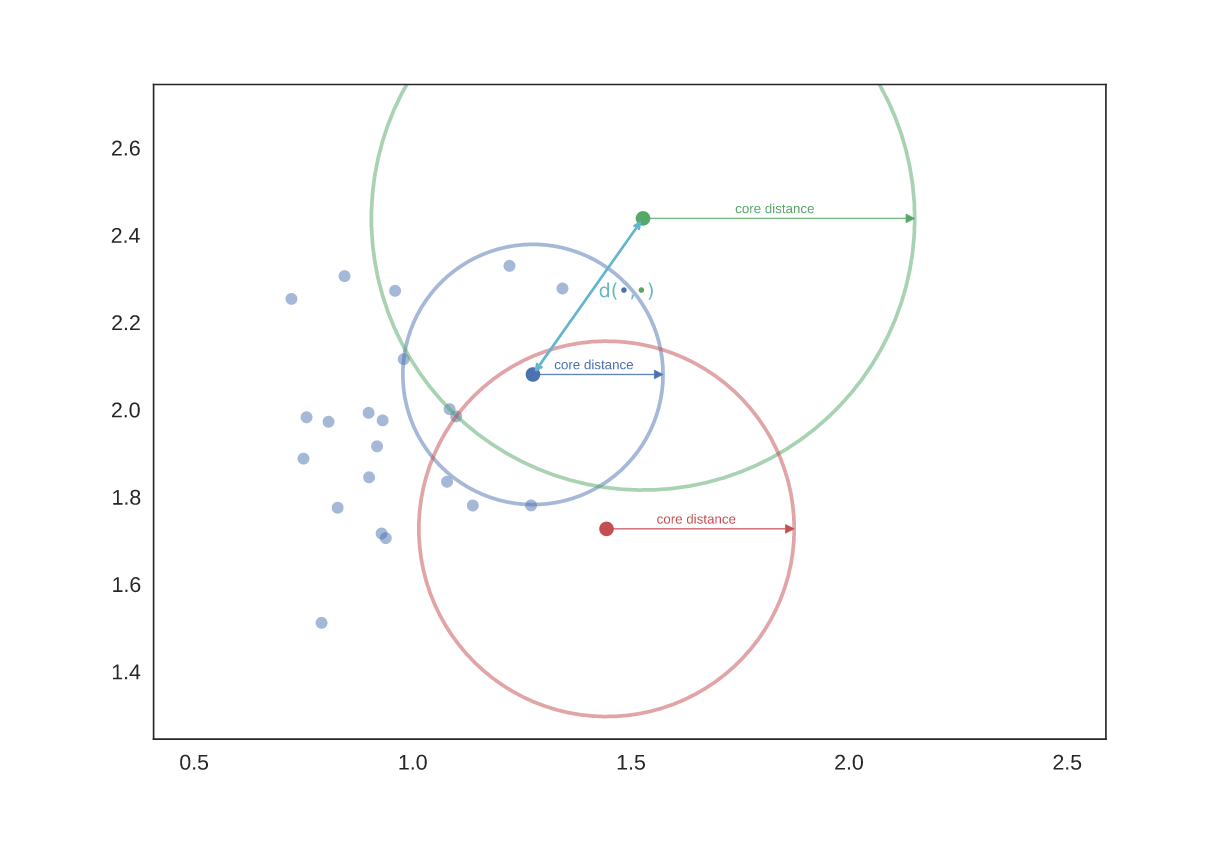

**Mutual Reachability Graph**: le graph complet où chaque pair de points est relié par un arc pondéré par sa MRD.

### Equivalence entre le mutual reachability graph et DBSCAN
(On introduit la notion d'ε-voisinage uniquement pour DBSCAN)  
**ε-voisinage**: pour un point A, ensemble des autres points à une distance < ε de A.

Le principe de DBSCAN, revisité dans le papier HDBSCAN, est de faire des groupements maximaux de points (=cluster) dont on sait que:
- chaque point à au moins mpts dans son ε-voisinage.
- toute paire de points (A, B) dans un groupement est connecté, c'est à dire que soit A est dans le ε-voisinage de B et reciproquement, soit il y a une chaîne de points entre A et B pour lesquels cette propriété tiens.

**NB**: Ce n'est pas *exactement* DBSCAN, on retire ici les points frontières.

Imaginons maintenant qu'on prenne le mutual reachability graph, qu'on enlève les arcs qui sont de poids > ε, et qu'on enlève les points isolés (outliers).
On a alors, pour tous points A, B connectés dans ce nouveau graph:  
$$d_{MRD}(A, B) \leq ε$$ $$ d_{core}(A) \leq ε$$ $$ d_{core}(B) \leq ε $$ $$ d(A, B) \leq ε $$

On a alors des groupements de points dont on sait qu'ils ont chacun au moins mpts dans leur ε-voisinage. De plus, chaque point des couples de points directement reliés est dans le ε-voisinage de l'autre. On est donc bien en présence d'un clustering équivalent à ce que produirait DBSCAN.

**Proposition**: Si on lance un algorithme de clustering hierarchique (Single Linkage) sur le mutual reachability graph, on obtient un dendogramme. Si on le coupe au niveau ε, on obtient un clustering de DBSCAN.

Cette méthode n'est cependant pas optimisée, les auteurs ont donc proposé d'implémenter cette idée d'une manière un peu différente.

### Utilisation du Minimum Spanning Tree (MST)
Tout d'abord, générons quelques points pour la suite.


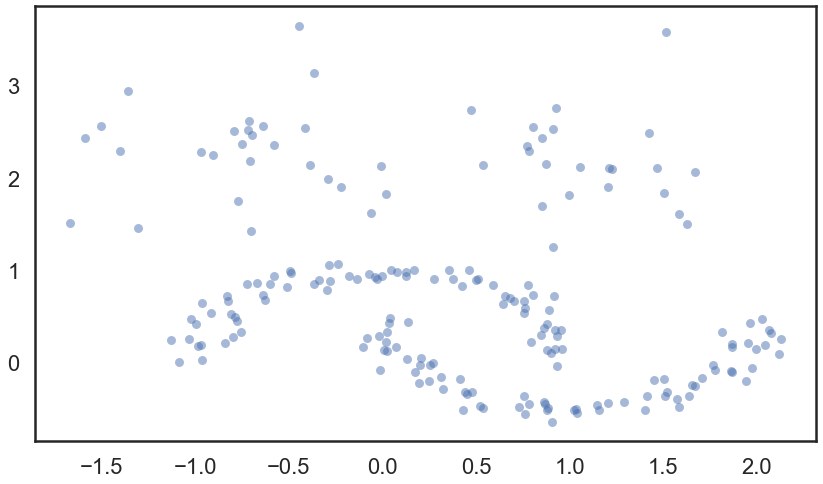

In [40]:
moons, _ = data.make_moons(n_samples=150, noise=0.08)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.40)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)

On lance hdbscan pour mieux illustrer la suite.

In [13]:
import hdbscan

In [41]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True)

La première étape consiste à générer un [MST](https://fr.wikipedia.org/wiki/Arbre_couvrant_de_poids_minimal), avec la particularité que chaque noeud possède un arc vers lui-même, avec comme poids sa core distance.

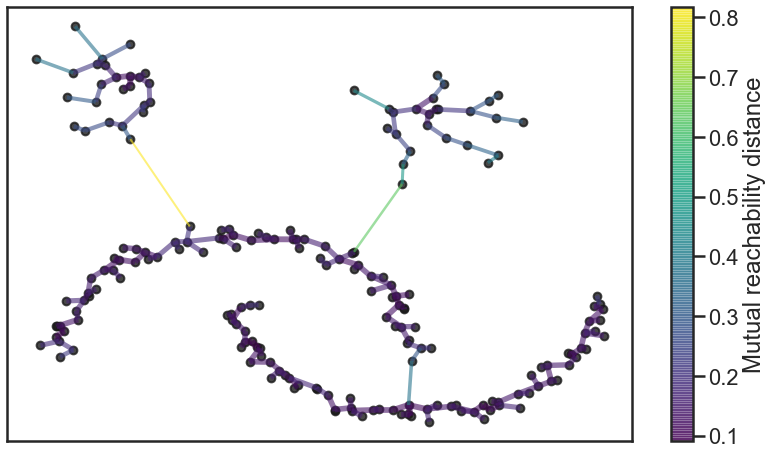

In [26]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', 
                                      edge_alpha=0.6, 
                                      node_size=60, 
                                      edge_linewidth=2)

En fait, le dendogramme générée par un clustering hirerarchique (en single linkage) depuis le mutual reacheability graph peut être créé en générant cet MST, et en supprimant successivement les liens selon leur poids décroissant. On peut générer cet MST avec [l'algorithme de Prim](https://fr.wikipedia.org/wiki/Algorithme_de_Prim), par exemple.

On obtient donc le dendogramme suivant:

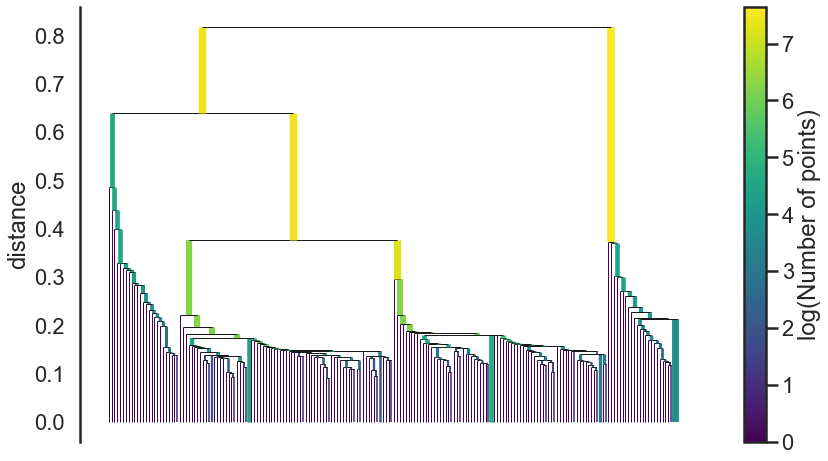

In [27]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

Le pseudocode principal de l'algorithme est le suivant:

```
1. Calculer la core distance de paramètre m_pts pour tout point X
2. Calculer le MST du Mutual Reachability Graph
3. Ajouter sur chaque noeud un arc pointant vers lui-même, ayant un poids de sa core_distance
4. Extraire le dendogramme depuis le MST:
    4.1 Pour la racine, mettre tous les objets dans le même cluster
    4.2 Pour chaque arc du MST, par ordre de poids décroissant (enlever tous ensemble ceux qui sont égaux):
        4.2.1 Définir la valeur courante du dendogramme sur la valeur de l'arc qu'on enlève
        4.2.2 Assigner de nouveaux labels au nouveaux clusters créés. Si l'un d'entre eux n'a plus d'arc, l'enlever (bruit).
        
```

La question maintenant va être de définir comment extraire des clusters depuis ce schéma. La méthode DBSCAN consisterait à tirer un trait horizontal, et de prendre tous les clusters de ce niveau. Mais nous voulons autoriser des variations de densités. Comment faire ?

### Simplification Hierarchique

On introduit un nouveau paramètre mclSize, qui correpond au nombre minimal d'éléments dans un cluster (les auteurs conseillent de fixer mclSize = mpts).

L'idée ici va être de "lisser" les clusters, en considérant que les clusters créés lors d'une séparation sont du bruit s'ils n'ont pas mclSize points, et donc ils ne constituent pas un vrai "split".

On redéfinit donc l'étape 4.2 de l'algorithme principal:

```
4.2 Pour chaque arc du MST, par ordre de poids décroissant (enlever tous ensemble ceux qui sont égaux):
      Si taille cluster formé < m_clSize -> Noise
      Si un seul cluster est créé -> garder le nom du cluster parent
      Si > 1 cluster, et que chacun à une taille > m_clSize -> assigner un nouveau label à chacun.
```

L'implémentation que nous utilisons de HDBSCAN nous permet de représenter les clusters au fil de l'algorithme.


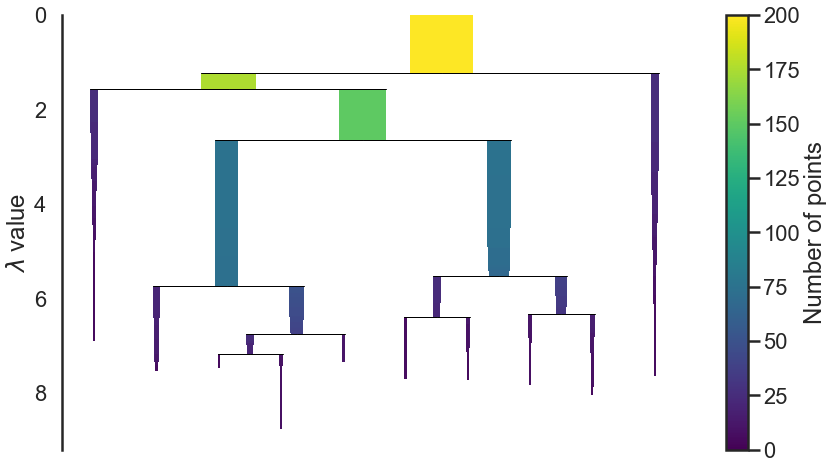

In [28]:
clusterer.condensed_tree_.plot()

On constate que certains points "tombent" des différents clusters lors de la progression de l'algorithme. La $\lambda\ value$ correspond à $\frac{1}{\epsilon}$.

Maintenant que nous avons une hierarchie simplifiée, il nous faut en extraire des clusters. 

### Extraction des clusters

Notons qu'il faut que pour un point donnée, celui-ci ne soit couvert que par un seul cluster.
L'idée ici va être d'utiliser une mesure de stabilité pour choisir quels clusters sont les plus pertinents.

On définit la stabilité d'un cluster par:

$$
S(C) = \sum_{x \in C}^{} (\lambda_{max}(x, C) - \lambda_{min}(C))
$$
où λmin est le niveau de densité pour lequel le cluster s'est créé, λmax(x, C) est le niveau de densité auquel l'objet x disparait de C (soit quand le cluster est split, soit quand il devient du bruit). Un cluster est donc d'autant plus stable qu'il contient de nombreux objets qui "restent" (càd ne sont pas considérés comme étant du bruit lorsqu'on augmente la densité minimale).

On va ensuite procéder de manière bottom-up, en considérant que tous les clusters du bas sont selectionnés, puis en remonte suivant la règle suivante, à chaque fusion de clusters: 
- si le cluster parent à une stabilité plus grande, le selectionner, et deselectionner les deux enfants.
- Sinon, garder les enfants et mettre la valeur du cluster selectionné égale à la somme des enfants.

On remonte ainsi jusqu'à la racine, et on obtient notre ensemble de clusters selectionnés.



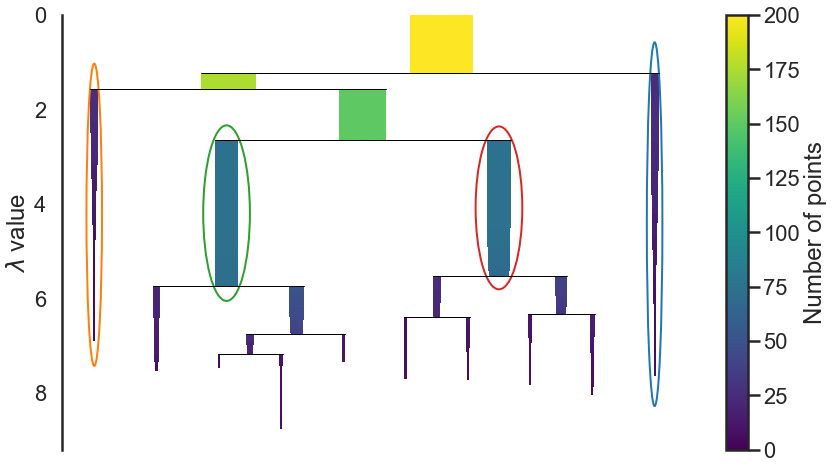

In [29]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

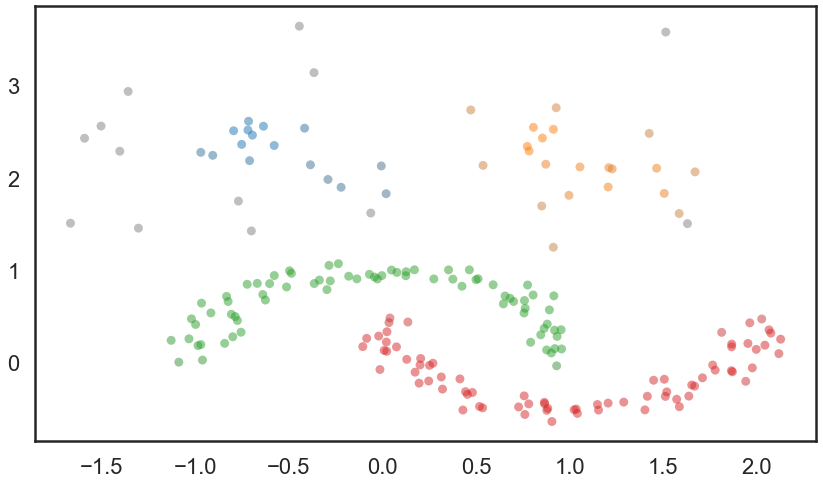

In [42]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat) 
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)

### Quelques comparaisons
Essayons avec le célèbre k-means.

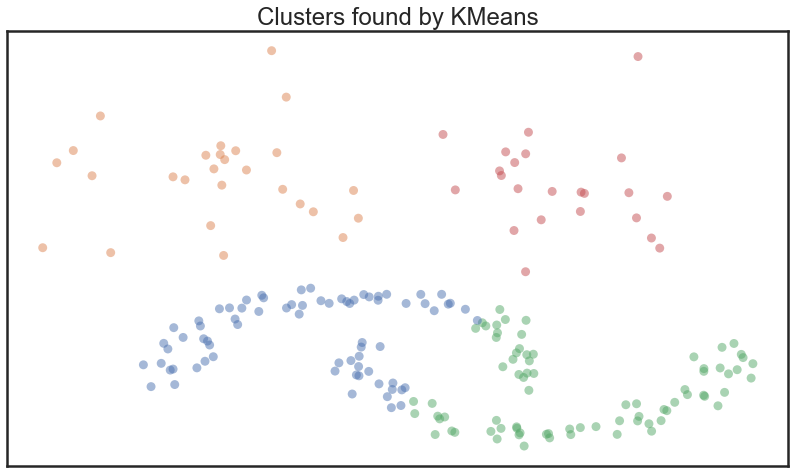

In [52]:
import sklearn.cluster as cluster
import time 
test_data

def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    
plot_clusters(test_data, cluster.KMeans, (), {'n_clusters':4})

Tous les points ont été sélectionnés, mais on voit qu'on a un problème pour les formes de croissants en bas.
Si on essaie de spécifier 3 classes, on obtient aussi un résultat peu satisfaisant:

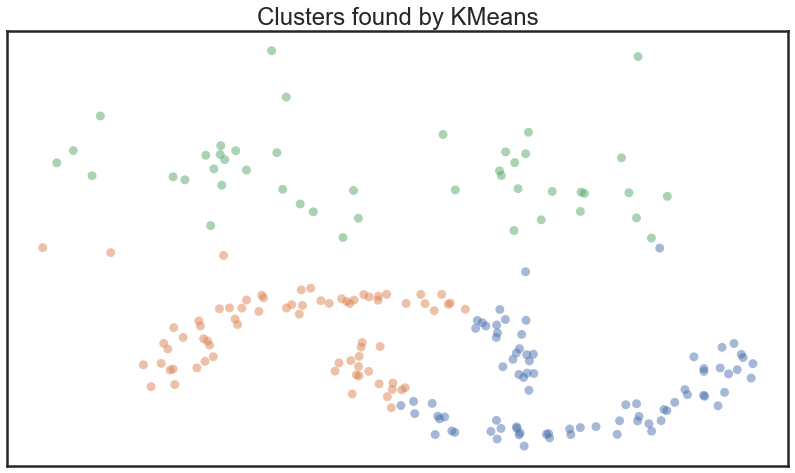

In [54]:
plot_clusters(test_data, cluster.KMeans, (), {'n_clusters':3})

Essayons maintenant avec DBSCAN:

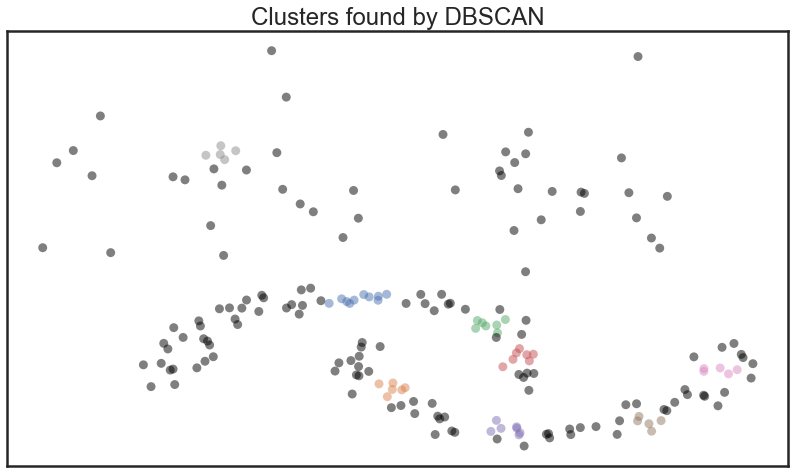

In [60]:
plot_clusters(test_data, cluster.DBSCAN, (), {'eps':0.1})

On a le problème du paramétrage qui n'est pas aisé. En tatonant, le meilleur clustering que je puisse trouver est le suivant:


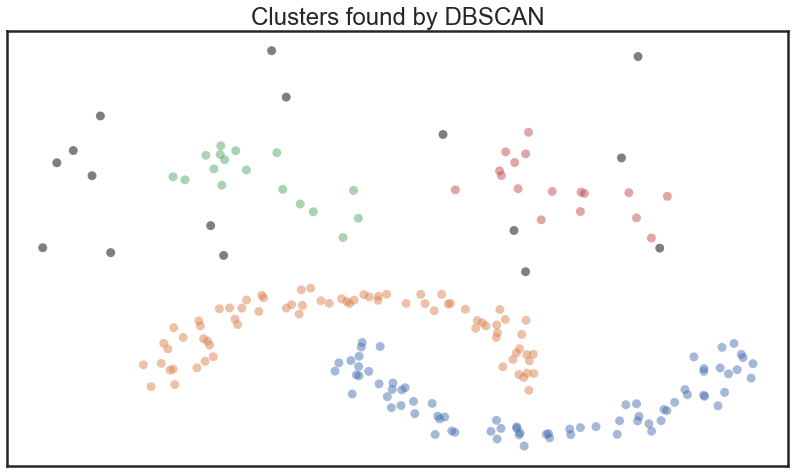

In [67]:
plot_clusters(test_data, cluster.DBSCAN, (), {'eps':0.35})

Pour plus d'expériences et de comparaisons, voir [1] et [2]. Pour des comparatifs de performances voir [5].

### Références:
[1] L. McInnes et J. Healy, « Accelerated Hierarchical Density Clustering », 2017 IEEE International Conference on Data Mining Workshops (ICDMW), p. 33‑42, nov. 2017.

[2] R. J. G. B. Campello, D. Moulavi, et J. Sander, « Density-Based Clustering Based on Hierarchical Density Estimates », in Advances in Knowledge Discovery and Data Mining, vol. 7819, J. Pei, V. S. Tseng, L. Cao, H. Motoda, et G. Xu, Éd. Berlin, Heidelberg: Springer Berlin Heidelberg, 2013, p. 160‑172.

[3] https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb (consulté le nov. 24, 2020).

[4] https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/How%20HDBSCAN%20Works.ipynb (consulté le nov. 24, 2020).

[5] https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Benchmarking%20scalability%20of%20clustering%20implementations-v0.7.ipynb (consulté le nov. 24, 2020).
